In [ ]:
!git clone https://github.com/openai/guided-diffusion.git

Cloning into 'guided-diffusion'...
remote: Enumerating objects: 113, done.
remote: Total 113 (delta 0), reused 0 (delta 0), pack-reused 113
Receiving objects: 100% (113/113), 67.86 KiB | 5.22 MiB/s, done.
Resolving deltas: 100% (47/47), done.


In [ ]:
!pip install TensorRT

  Preparing metadata (setup.py) ... done
  Created wheel for TensorRT: filename=tensorrt-8.6.1-py2.py3-none-any.whl size=16972 sha256=7da006d409612342596f3d8692bbcec6e57815db44f1075c641891235adf7dcc
  Stored in directory: /root/.cache/pip/wheels/6d/29/56/abdffd4c604f255b5254bef3f1c598ab7811ea020540599438
Successfully built TensorRT


In [ ]:
import scipy
import requests
import tqdm

# FID 256x256 на 30 сгенерированных изображениях в сэмпле

In [ ]:
!python /content/guided-diffusion/evaluations/evaluator.py /content/drone_references_256x256.npz /content/DiT-XL-2.npz

2023-07-31 13:49:40.353727: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-31 13:49:41.945604: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-07-31 13:49:43.590166: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-31 13:49:44.135006: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

# FID 256x256 на 480 сгенерированных изображениях в сэмпле DiT

In [ ]:
!unzip /content/DiT-XL-2-0015005_3000-size-256-vae-ema-cfg-7.0-seed-42_2.zip

Archive:  /content/DiT-XL-2-0015005_3000-size-256-vae-ema-cfg-7.0-seed-42_2.zip
  inflating: DiT-XL-2-0015005_3000-size-256-vae-ema-cfg-7.0-seed-42_2.npz  


In [ ]:
!python /content/guided-diffusion/evaluations/evaluator.py /content/drone_references_256x256.npz /content/DiT-XL-2-480.npz

2023-07-31 15:31:50.589534: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-31 15:31:51.511434: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-07-31 15:31:53.309474: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-31 15:31:53.342595: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

In [ ]:
# проверка того, что npz файл корректно упакован
# при правильной упаковке код сработает
from numpy import load

data = load('/content/drone_references_256x256_1280.npz')
lst = data.files
for item in lst:
    print(item)
    print(data[item])

In [ ]:
# первое значение показывает количество изображений в сэмпле
data['arr_0'].shape

(10, 256, 256, 3)

# Создание сэмплов исходного кастомного датасета

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/drone_archive.zip

In [ ]:
import os
import shutil

In [ ]:
os.mkdir('/content/images')

In [ ]:
# перенос изображений в отдельную папку
image_format = ['jpg', 'png']
def clean():
    files = os.listdir('/content/drone_archive/drone_dataset_yolo/dataset_txt/')
    for items in files:
        extension = items.split(".")
        if len(extension) > 1 and (
                extension[1].lower() == "jpg" or
                extension[1].lower() == "png"):
            file = '/content/drone_archive/drone_dataset_yolo/dataset_txt' + "/" + items
            new_path = '/content/images/' + items
            shutil.move(file, new_path)
clean()

In [ ]:
import numpy as np
from PIL import Image

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
def create_npz_from_sample_folder(sample_dir, num):
    """
    Builds a single .npz file from a folder of .jpg samples.
    """
    new_width  = 256
    new_height = 256
    samples = []
    k = 0
    for i in tqdm(range(num)):
        sample_pil = Image.open(sample_dir + os.listdir(sample_dir)[i])
        # отрисовка первого изображения исходного размера
        if os.listdir(sample_dir)[i] == os.listdir(sample_dir)[0]:
            display(sample_pil)

        sample_pil = sample_pil.resize((new_width, new_height), Image.ANTIALIAS)

        # отрисовка первого изображения для просмотра измененного размера
        if os.listdir(sample_dir)[i] == os.listdir(sample_dir)[0]:
          display(sample_pil)
        sample_np = np.asarray(sample_pil).astype(np.uint8)

        # отбор изображений одинакого размера
        if sample_np.shape == (new_height, new_width, 3):
            samples.append(sample_np)
            k += 1
    samples = np.stack(samples)
    print('количество картинок в сэмпле:', k)
    print(samples.shape[1], samples.shape[2])
    #print((num, samples.shape[1], samples.shape[2], 3))
    # assert samples.shape == (num, samples.shape[1], samples.shape[2], 3)
    npz_path = f'/content/drone_references_256x256_{k}.npz'
    np.savez(npz_path, arr_0=samples)
    print(f"Saved .npz file to {npz_path} [shape={samples.shape}].")
    return npz_path

  0%|          | 0/1359 [00:00<?, ?it/s]

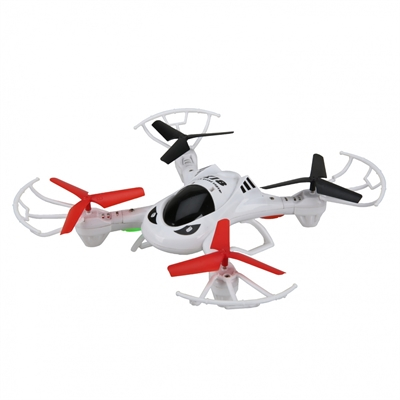

<ipython-input-16-f764c795e62c>:15: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  sample_pil = sample_pil.resize((new_width, new_height), Image.ANTIALIAS)


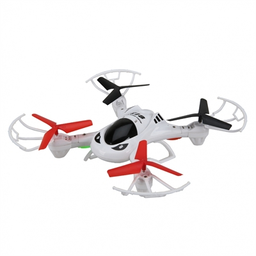

количество картинок в сэмпле: 1280
256 256
Saved .npz file to /content/drone_references_256x256_1280.npz [shape=(1280, 256, 256, 3)].


'/content/drone_references_256x256_1280.npz'

In [ ]:
create_npz_from_sample_folder('/content/images/', 1359)